In [18]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [19]:
def map_int_to_direction(input):
    if input == 0:
        return maze_library.Direction.North
    if input == 1:
        return maze_library.Direction.East
    if input == 2:
        return maze_library.Direction.South
    else:
        return maze_library.Direction.West

In [ ]:
env = maze_library.init_environment_python(16,16,5)
maze_library.create_kruzkals_maze(env)
maze_library.make_maze_imperfect(env)

In [21]:
def action_result_to_tuple(action_result):
    """
    Converts an ActionResult object into a tuple.

    Args:
        action_result (ActionResult): The result of an action in the environment.

    Returns:
        tuple: (observation, reward, done, truncated, info)
    """
    observation = action_result.observation  # The new observation after taking action
    reward = action_result.reward  # Reward received
    done = action_result.is_done  # Whether the episode is finished
    truncated = action_result.is_truncated  # Whether the episode was truncated
    info = action_result.info # Additional info

    return observation, reward, done, truncated, info


In [22]:
def action_result_to_input_vector(state, info):
    available_paths = state.available_paths
    visited_paths = state.visited_paths
    return np.array([
        available_paths.get(maze_library.Direction.North, 0)/10,
        visited_paths.get(maze_library.Direction.North, False),
        available_paths.get(maze_library.Direction.East, 0)/10,
        visited_paths.get(maze_library.Direction.East, False),
        available_paths.get(maze_library.Direction.South, 0)/10,
        visited_paths.get(maze_library.Direction.South, False),
        available_paths.get(maze_library.Direction.West, 0)/10,
        visited_paths.get(maze_library.Direction.West, False),
        info.previous_direction,
        state.current_location[0] / 10,
        state.current_location[1] / 10,
        state.end_node[0] / 10,
        state.end_node[1] / 10,
        info.previous_node[0] / 10,
        info.previous_node[1] / 10,
        info.manhattan_distance / 10,
        info.goal_dx/5,
        info.goal_dy/5,
        info.visited_amount 

    ])

In [23]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [19]  # == env.observation_space.shape
n_outputs = 4  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])



In [24]:
print("Initial Q-values:", model.predict(np.random.rand(1, 19)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Initial Q-values: [[ 0.13796592 -0.05744591 -0.39422947 -0.3292548 ]]


In [25]:
def epsilon_greedy_policy(flat_state, epsilon):
    if np.random.rand() < epsilon:
        # Choose only from valid actions
        return np.random.choice(n_outputs)
    else:
        Q_values = model.predict(flat_state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()


In [26]:
from collections import deque

replay_buffer = deque(maxlen=8000)

In [27]:
def sample_experiences(batch_size):
    sorted_experiences = sorted(replay_buffer, key=lambda exp: abs(exp[2]), reverse=True)
    half_batch = batch_size // 2

    # Ensure there are enough samples to choose from
    num_experiences = len(sorted_experiences)
    if num_experiences < batch_size:
        batch = sorted_experiences
    else:
        high_priority_samples = sorted_experiences[:half_batch]
        random_samples = [sorted_experiences[i] for i in np.random.choice(num_experiences, half_batch, replace=False)]
        batch = high_priority_samples + random_samples
    
    return [
        np.array([experience[field_index] for experience in batch], dtype=np.float32)
        for field_index in range(6)
    ]



In [28]:
reward_log = []
def play_one_step(env, state, info, epsilon):
    flat_state = action_result_to_input_vector(state, info)
    action = epsilon_greedy_policy(flat_state, epsilon)
    action_obj = maze_library.create_action(map_int_to_direction(action))
    next_state, reward, done, truncated, new_info = action_result_to_tuple(env.take_action(action_obj))
    flat_next_state = action_result_to_input_vector(next_state, new_info)
    reward_log.append(reward)
    replay_buffer.append((flat_state, action, reward, flat_next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [29]:
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
highest_reward = -1000000

In [30]:
batch_size = 64
discount_factor = 0.96
q_value_log = []
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
loss_fn = tf.keras.losses.Huber(delta=1.0) # Use the class
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        q_value_log.extend(Q_values.numpy().flatten())
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [31]:
# Visualization function
def plot_q_values():
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


Episode: 0, Steps: 5, eps: 1.000, reward = -24.6
Episode: 10, Steps: 17, eps: 0.996, reward = -44.2
Episode: 20, Steps: 6, eps: 0.993, reward = -23.900000000000002
Episode: 30, Steps: 6, eps: 0.989, reward = -24.6
Episode: 40, Steps: 17, eps: 0.985, reward = -37.3
Episode: 48, Steps: 30, eps: 0.982, reward = 13.999999999999993
Episode: 50, Steps: 17, eps: 0.981, reward = -46.3
Episode: 60, Steps: 6, eps: 0.978, reward = -26.6
Episode: 70, Steps: 28, eps: 0.974, reward = -59.59999999999999
Episode: 80, Steps: 11, eps: 0.970, reward = -28.5
Episode: 90, Steps: 16, eps: 0.967, reward = -41.0
Episode: 95, Steps: 20, eps: 0.965, reward = 18.399999999999995
Episode: 100, Steps: 13, eps: 0.963, reward = -40.8
Episode: 104, Steps: 33, eps: 0.961, reward = 11.099999999999994
Episode: 110, Steps: 40, eps: 0.959, reward = -69.80000000000001
Episode: 120, Steps: 45, eps: 0.956, reward = -72.5
Episode: 130, Steps: 16, eps: 0.952, reward = -39.0
Episode: 132, Steps: 34, eps: 0.951, reward = 3.600000

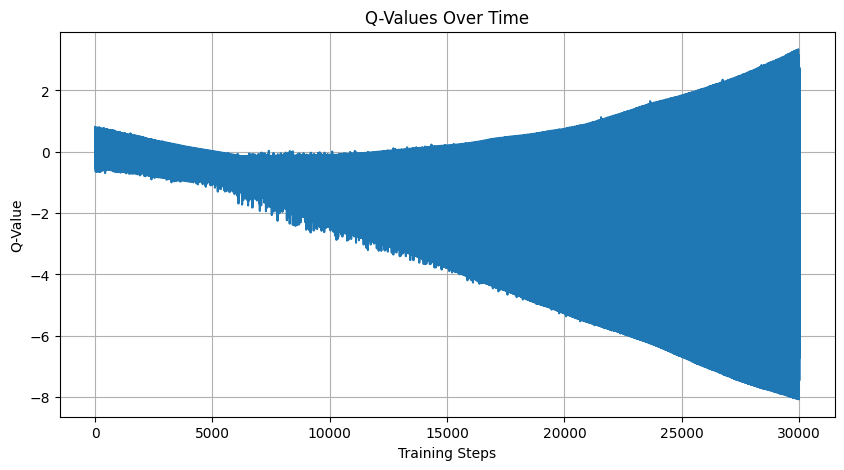

Episode: 500, Steps: 11, eps: 0.815, reward = -30.5
Episode: 510, Steps: 14, eps: 0.811, reward = -33.2
Episode: 520, Steps: 11, eps: 0.807, reward = -30.900000000000002
Episode: 522, Steps: 27, eps: 0.807, reward = 11.999999999999993
Episode: 530, Steps: 21, eps: 0.804, reward = -51.099999999999994
Episode: 536, Steps: 16, eps: 0.801, reward = 25.800000000000004
Episode: 540, Steps: 8, eps: 0.800, reward = -21.4
Episode: 550, Steps: 36, eps: 0.796, reward = -77.30000000000001


In [ ]:
steps = 3000

# In the plotting function:
for episode in range(steps):
    result = env.reset()   
    obs, reward, done, truncated, info = action_result_to_tuple(result)
    cumilative_reward = 0
    for step in range(steps):
        epsilon = max(1 - episode / (steps * 0.9), 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, info, epsilon)
        cumilative_reward += reward
        if done or truncated:
            break

    # Extra debug information
    if episode% 10 == 0 or cumilative_reward > 0:
        print(f"\rEpisode: {episode}, Steps: {step}, eps: {epsilon:.3f}, reward = {cumilative_reward}")
    rewards.append(cumilative_reward)
    
    if cumilative_reward > highest_reward:
        best_weights = model.get_weights()
        highest_reward = cumilative_reward

    if episode > 30:
        training_step(batch_size)
    if episode % 500 == 499:
        plot_q_values()
        
    with open(f'../mazeLogs/solve{episode}.json', 'w') as file:
        file.write(env.to_json_python())

    

model.set_weights(best_weights)  # extra code – restores the best model weights

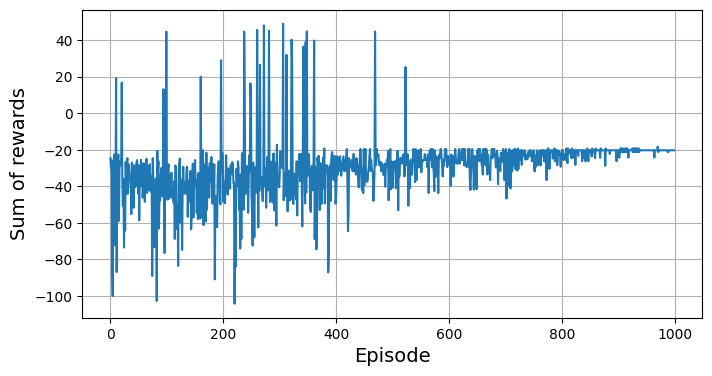

In [ ]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

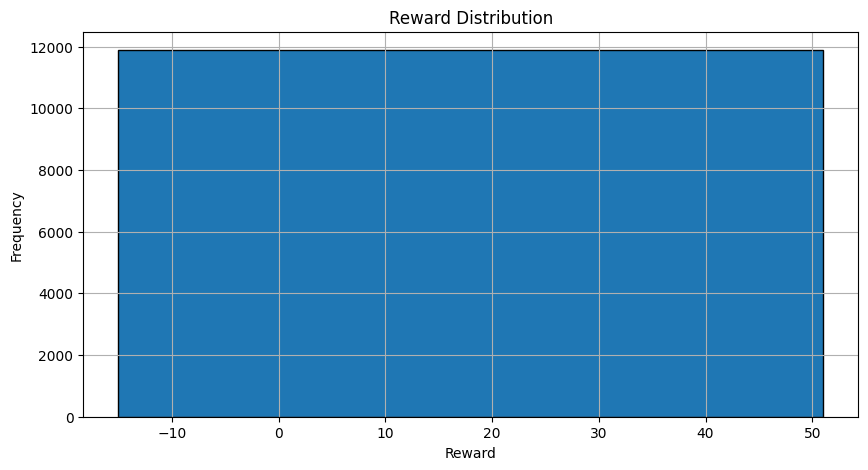

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(reward_log, bins=1, edgecolor='black')
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()